In [45]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from scipy.signal import wiener
from tqdm import tqdm

fe.set_log_level(50)


# ##########################
# step 0: relevant constants
DATA_FILE = "../data/Run08_G0_dt4.0_de1.0_ne5_velocity.nc"
length_ref = 0.1
B = 5
L = 20
r = 0.5

# #######################################
# step 1: read in and preprocess the data
ds = xr.open_dataset(DATA_FILE)

# first we get the locations of the observation points with respect to our grid
ds_zero = ds.isel(time=0)
ds_zero_missing = ds_zero.where(ds_zero.isnull(), drop=True)

x = ds_zero.coords["x"].to_numpy() / length_ref
y = ds_zero.coords["y"].to_numpy() / length_ref

x_missing = ds_zero_missing.coords["x"].to_numpy() / length_ref
y_missing = ds_zero_missing.coords["y"].to_numpy() / length_ref

# compute global `x` coordinates
x_displacement = np.min(x[x > np.max(x_missing)])
x_center_displacement = r - x_displacement
x_global_displacement = L / 2 + x_center_displacement
x_global = x + x_global_displacement

# compute global `y` coordinates
y_mid = y[len(y) // 2]
y_global = B / 2 + (y - y_mid)

# and create meshgrid according to our current setup
x_mg, y_mg = np.meshgrid(x_global, y_global, indexing="ij")

In [46]:
# then we average the data spatially
u_spatial_averaged = np.mean(ds.U, axis=(1, 2, 3))
v_spatial_averaged = np.mean(ds.V, axis=(1, 2, 3))

# start from where the flow is nearest to 0.
idx_start = np.argmin(np.abs(u_spatial_averaged.values - 0.))
idx_end = len(u_spatial_averaged.values)

u_depth_averaged = np.mean(ds.U, axis=-1)
v_depth_averaged = np.mean(ds.V, axis=-1)

u_depth_averaged = u_depth_averaged.isel(time=slice(idx_start, idx_end))
v_depth_averaged = v_depth_averaged.isel(time=slice(idx_start, idx_end))

u_depth_averaged["time"].dtype == np.datetime64
u_depth_averaged = u_depth_averaged.assign_coords(
    dict(time_rel=((u_depth_averaged["time"] 
                    - u_depth_averaged["time"][0]) * 1e-9).astype(float)))
v_depth_averaged = v_depth_averaged.assign_coords(
    dict(time_rel=((v_depth_averaged["time"] 
                    - v_depth_averaged["time"][0]) * 1e-9).astype(float)))
u_depth_averaged

<xarray.DataArray 'U' (time: 218, x: 64, y: 48)>
array([[[ 3.32461794e-04,  2.28321062e-04,  8.41260803e-05, ...,
         -1.01692155e-03, -1.01736529e-03, -9.70264850e-04],
        [ 3.21461574e-04,  2.24298969e-04,  1.09306077e-04, ...,
         -9.69385378e-04, -9.40876073e-04, -9.25488003e-04],
        [ 3.67069255e-04,  2.81094599e-04,  1.97430882e-04, ...,
         -8.99291344e-04, -8.80503867e-04, -8.63772164e-04],
        ...,
        [-6.03561978e-05, -5.32024491e-05, -4.94446984e-05, ...,
          1.52195909e-05,  1.64824203e-05,  6.20214198e-05],
        [-7.88615528e-05, -7.63504324e-05, -7.34907335e-05, ...,
          5.13749018e-06,  5.06688787e-06,  3.32368394e-05],
        [-8.18966817e-05, -6.64736089e-05, -6.00989855e-05, ...,
          1.39096679e-05,  1.16041639e-05,  2.41744227e-05]],

       [[ 1.19976296e-03,  1.14448214e-03,  1.09443390e-03, ...,
          1.43159248e-04,  1.01443262e-04,  4.87466137e-05],
        [ 1.24073902e-03,  1.17356282e-03,  1.14517830e-03, ...,
          1.32469842e-04,  7.17302014e-05,  6.16075158e-05],
        [ 1.26315679e-03,  1.21119768e-03,  1.19033824e-03, ...,
          7.33961876e-05,  4.34683686e-05,  4.19072347e-05],
...
        [ 5.18643738e-03,  5.16462866e-03,  5.12519878e-03, ...,
          4.75528122e-03,  4.62379673e-03,  4.56663371e-03],
        [ 5.32332358e-03,  5.21578101e-03,  5.13171637e-03, ...,
          4.83586620e-03,  4.69327275e-03,  4.60661829e-03],
        [ 5.30132870e-03,  5.27395645e-03,  5.15396207e-03, ...,
          4.86745546e-03,  4.78135690e-03,  4.72308819e-03]],

       [[ 5.25905682e-03,  5.29201378e-03,  5.38426547e-03, ...,
          4.83100722e-03,  4.68103117e-03,  4.56165768e-03],
        [ 5.23810580e-03,  5.24690822e-03,  5.32682273e-03, ...,
          4.84821459e-03,  4.65627420e-03,  4.54393960e-03],
        [ 5.11630452e-03,  5.16752014e-03,  5.21405663e-03, ...,
          4.84401385e-03,  4.66261532e-03,  4.57529936e-03],
        ...,
        [ 4.73105304e-03,  4.70733605e-03,  4.63190288e-03, ...,
          4.43145405e-03,  4.35508301e-03,  4.35580333e-03],
        [ 4.77076593e-03,  4.74940241e-03,  4.68431614e-03, ...,
          4.44503883e-03,  4.41397486e-03,  4.43688257e-03],
        [ 4.78290171e-03,  4.76356556e-03,  4.74462687e-03, ...,
          4.43408266e-03,  4.45973088e-03,  4.42980520e-03]]])
Coordinates:
  * time      (time) datetime64[ns] 2016-07-14T23:43:12.464000 ... 2016-07-14...
  * x         (x) float32 0.01056 0.01584 0.02112 ... 0.3326 0.3379 0.3432
  * y         (y) float32 0.01056 0.01584 0.02112 ... 0.2482 0.2534 0.2587
    time_rel  (time) float64 0.0 4.0 8.0 12.0 16.0 ... 864.0 868.0 872.0 876.0

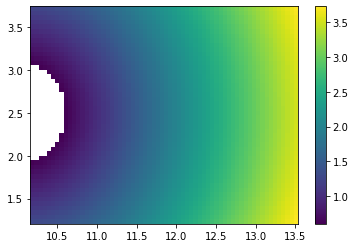

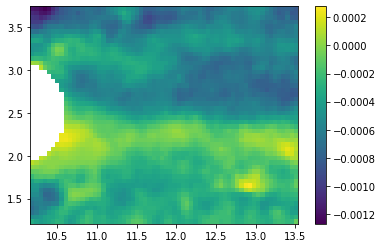

0.003205394745324609 0.03083272618032106
(2938,) (2938,) (218, 2938)
(2938, 2)


In [47]:
ud = u_depth_averaged.to_numpy()
vd = v_depth_averaged.to_numpy()
nt_obs = ud.shape[0]

c = np.sqrt((x_mg - 10)**2 + (y_mg - 2.5)**2)
mask = (c <= 0.6)

c_filtered = np.copy(c)
c_filtered[mask] = np.nan

# filter the data as needed
ud_filtered = np.copy(ud[120, :, :])
ud_filtered[mask] = np.nan

im = plt.pcolormesh(x_mg, y_mg, c_filtered)
plt.colorbar(im)
plt.show()

im = plt.pcolormesh(x_mg, y_mg, ud_filtered)
plt.colorbar(im)
plt.show()

# and check that things are sensible
assert ud.shape == vd.shape
assert ud[0, :, :].shape == x_mg.shape
assert vd[0, :, :].shape == y_mg.shape

filter_width = 3
nrows, ncols = vd[0, :, :].shape

sigma_u_est = np.zeros((nrows, ncols))
sigma_v_est = np.zeros((nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        ud_filtered = wiener(ud[:, i, j], filter_width)
        vd_filtered = wiener(vd[:, i, j], filter_width)
        
        sigma_u_est[i, j] = np.std(ud[:, i, j] - ud_filtered)
        sigma_v_est[i, j] = np.std(vd[:, i, j] - vd_filtered)
        
# check that the min/max variances are sound
print(np.amin(sigma_u_est[~np.isnan(sigma_u_est)] / 0.01), 
      np.amax(sigma_u_est[~np.isnan(sigma_u_est)] / 0.01))

# at this stage the data is ready to be assimilated into the model
# mask things as needed
x_obs = np.vstack((x_mg[~mask], y_mg[~mask])).T
t_obs = u_depth_averaged.coords["time_rel"].to_numpy()
u_obs = ud[:, ~mask]
v_obs = vd[:, ~mask]

print(x_mg[~mask].shape,  y_mg[~mask].shape, ud[:, ~mask].shape)
print(x_obs.shape)

# check that any NaNs are absent
assert np.any(np.isnan(u_obs)) == False
assert np.any(np.isnan(v_obs)) == False

In [51]:
print(t_obs / 120)

[0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667
 1.         1.03333333 1.06666667 1.1        1.13333333 1.16666667
 1.2        1.23333333 1.26666667 1.3        1.33333333 1.36666667
 1.4        1.43333333 1.46666667 1.5        1.53333333 1.56666667
 1.6        1.63333333 1.66666667 1.7        1.73333333 1.76666667
 1.8        1.83333333 1.86666667 1.9        1.93333333 1.96666667
 2.         2.03333333 2.06666667 2.1        2.13333333 2.16666667
 2.2        2.23333333 2.26666667 2.3        2.33333333 2.36666667
 2.4        2.43333333 2.46666667 2.5        2.53333333 2.56666667
 2.6        2.63333333 2.66666667 2.7        2.73333333 2.76666667
 2.8        2.83333333 2.86666667 2.9        2.93333333 2.9666